# Mw7.3 Maduo event - Southern Qinghai 


Handling and visualization of the rake data generated by Dr. Mathilde Marchandon from her slip model for the Maduo event

Data key:
> x,y,z coordinates of each subfault barycenter, the strike slip (positive for left-lateral slip), the dip slip (positive for dip-slip), and the rake (positive for left-lateral dip slip and negative for left-lateral normal slip)
>
> fault_slip_sgmt_1.txt, fault_slip_sgmt_2.txt, fault_slip_sgmt_3.txt is for the first, second, and third fault segment respectively (from west to east). 
>
> Coordinates are in UTM zone 47N, the slip is in meter and the rake in degree.

> by J. Hayek (05.05.2022)

In [48]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
plt.style.use("science")


import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [49]:
RakeFilePath = "/home/nico/Documents/TEAR/SeisSolMaduoEvent/1_SourceData/RakeMaduoFaultSlipModel/"
FilesList = ["fault_slip_sgmt_1.in", "fault_slip_sgmt_2.in", "fault_slip_sgmt_3.in"]

In [50]:
# Read the data
def getDataRake(i, RakeFilePath = RakeFilePath, FilesList = FilesList):
    
    Fault_i = pd.read_csv(RakeFilePath+FilesList[i],sep=" ", header=None, 
                          names=["x","y","z", "StrikeSlip", "DipSlip", "Rake"])
    
    return Fault_i

In [51]:
LonLat2LatLonZoomOut = lambda ext, Zoom: [ext[2]-Zoom, ext[3]+Zoom, ext[0]-Zoom, ext[1]+Zoom]

def MapGeoLoc(Window, proj, ZoomOut = 5):
    ax = plt.axes(projection=proj)
    stamen_terrain = cimgt.StamenTerrain()
    #ax.add_image(stamen_terrain, 8)
    #ax.coastlines('10m')
    ax.set_extent(LonLat2LatLonZoomOut(Window, ZoomOut), ccrs.PlateCarree())
    gl=ax.gridlines(crs=proj,draw_labels=True)
    return ax



In [52]:

# First dataframe added to a list of dataframes
##### First file (extra empty column, requires cleaning up the data a bit)
i=0
Fault_i = pd.read_csv(RakeFilePath+FilesList[i],sep=" ", header=None, 
                          names=["x","y","z", " ","StrikeSlip", "DipSlip", "Rake"])
del Fault_i[" "]

Fault_i["FaultBranch"] = 0

FaultPatches = Fault_i.copy()


#### Second and third dataframes
for i in range(1,3):
    Fault_i = getDataRake(i)
    
    Fault_i["FaultBranch"] = i
    
    FaultPatches = FaultPatches.append(Fault_i,ignore_index=True)


In [53]:
cols = ['StrikeSlip','DipSlip']

FaultPatches["TotalSlip"] = np.sqrt(np.square(FaultPatches[cols]).sum(axis=1))

In [54]:
def getColor(val):
    colors_set = ['blue', 'red', 'black']
    return colors_set[val]

In [55]:
MaduoWindow = [34.3, 34.9, 97.4, 99.5]

DataProj=ccrs.UTM(47,southern_hemisphere=False)

# X,Y Coordinates projection
proj=ccrs.PlateCarree()
DataX = FaultPatches.iloc[:]["x"]
DataY = FaultPatches.iloc[:]["y"]

ProjScattered = proj.transform_points(DataProj, np.array(DataX), np.array(DataY))

/tmp/ipykernel_546659/111220298.py:5: DeprecationWarning:

The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.



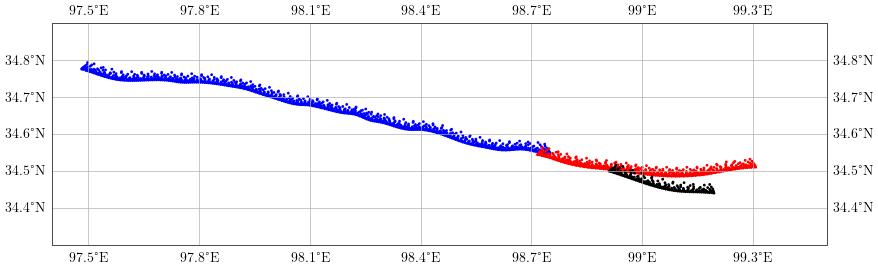

In [56]:
WindowInterest = MaduoWindow

fig = plt.figure(figsize=(10, 10), dpi=100)
ax = MapGeoLoc(WindowInterest, proj, 0)

plt.scatter(ProjScattered[:,0], ProjScattered[:,1], c=FaultPatches["FaultBranch"].apply(getColor), s=1)

$\\xb0E$

In [57]:
def AddColorbar(fig,ax,sc, **kwargs):
    cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(sc, cax=cax, **kwargs) # Similar to fig.colorbar(im, cax = cax)
    return cax

def SetCbarFormat(cax, title):
    cax.set_ylabel(title)

/tmp/ipykernel_546659/111220298.py:5: DeprecationWarning:

The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.



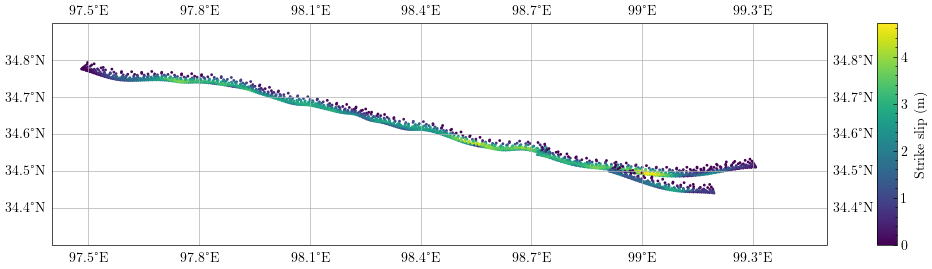

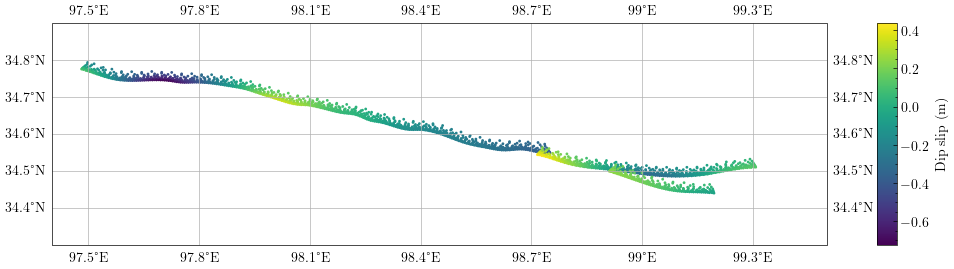

In [58]:
WindowInterest = MaduoWindow

fig = plt.figure(figsize=(10, 10), dpi=100)
ax = MapGeoLoc(WindowInterest, proj, 0)

sc = ax.scatter(ProjScattered[:,0], ProjScattered[:,1], c=FaultPatches["StrikeSlip"], s=1)
cax = AddColorbar(fig,ax,sc)
SetCbarFormat(cax, "Strike slip (m)")

fig = plt.figure(figsize=(10, 10), dpi=100)
ax = MapGeoLoc(WindowInterest, proj, 0)
sc = ax.scatter(ProjScattered[:,0], ProjScattered[:,1], c=FaultPatches["DipSlip"], s=1)
cax = AddColorbar(fig,ax,sc)
SetCbarFormat(cax, "Dip slip (m)")

In [59]:
from plotly.express import scatter_3d, scatter

In [60]:
FaultPatches.columns

Index(['x', 'y', 'z', 'StrikeSlip', 'DipSlip', 'Rake', 'FaultBranch',
       'TotalSlip'],
      dtype='object')

In [61]:
fig = scatter_3d(FaultPatches, "x", "y", "z", color = "StrikeSlip")
fig.update_traces(marker_size = 2)

fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=30, y=10, z=1))

# Notes

 something to take into account is the differences in notation, especially:
 * The slip model appear use the strike slip as positive for left-lateral slip
 
 
 > The strike slip and the dip slip can be plotted as the total or partial slip
 
 
 Change the 
 $R_{initial stress}$ change to 0.9 (maybe 0.89 for the second tagged fault)
 
 rather change the $S_{Hmax}$ 
 
 From Mathildes data, the seismogenic zone reaches max 10km, and 6km has the most higher values on the first branch, so what we can do is choosing a nucleation patch shallower, maybe at 6km depth, however it is already at 6km
 
 * vary the dip angle to check how it behaves towards the data
 
 * Perhaps change the strike angle of the initial stress instead of varying the $R_0$ parameter fault-wise, which is against the standard approach in rupture dynamics
 
 * WE got strong velocity weakening (rs_a), increasing the node at -3e3 to 0.01 to 0.02 will enhance the velocity strengthening of the shallow region to check the slip. In shallower layer it doesnt rupture that much from observations in the slip model of Mathilde therefore we can think of increasing/ enhancing the velocity strengthening parameter in shallower regions and see if this agrees with the slip model of Mathilde

# Using the original mesh to ease visualization

the mesh contains the vertex locations and the list of face connections for the mesh, per fault surface

In [62]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [63]:
Mesh_FaultSlip = "/home/nico/Documents/TEAR/SeisSolMaduoEvent/1_SourceData/MaduoFaultSlipMesh/"
VertexFileList = ["fault_geom_sgmt_1_coord.txt", "fault_geom_sgmt_2_coord.txt", "fault_geom_sgmt_3_coord.txt"]
FacesFileList = ["fault_geom_sgmt_1_tri.txt", "fault_geom_sgmt_2_tri.txt", "fault_geom_sgmt_3_tri.txt"]

In [64]:
Vertex_i = lambda idx,Mesh_FaultSlip,VertexFileList: pd.read_csv(Mesh_FaultSlip+VertexFileList[idx],sep=" ", header=None,
                                                                 names=["x","y","z"])
FacesIDX_i = lambda idx,Mesh_FaultSlip,FacesFileList: pd.read_csv(Mesh_FaultSlip+FacesFileList[idx],sep=" ",  header=None,
                                                                 names=["i","j","k"])
FacesValues_i = lambda idx,FaultPatches,DataName: FaultPatches.loc[FaultPatches['FaultBranch'] == idx, DataName]

def GetMeshData(Vertex, FacesIDX, FacesValues, **kwargs):
    
    DataProj=ccrs.UTM(47,southern_hemisphere=False)
    proj=ccrs.PlateCarree()
    DataX = Vertex['x']
    DataY = Vertex['y']

    ProjData = proj.transform_points(DataProj, np.array(DataX), np.array(DataY))
    
    TheMesh = go.Mesh3d(
                            # Vertex of the surface
                            x=ProjData[:,0],
                            y=ProjData[:,1],
                            z=Vertex['z'],        
                            # Intensity of each vertex, which will be interpolated and color-coded
                            intensity = FacesValues,
                            intensitymode='cell',
                            # i, j and k give the vertices of triangles
                            i = FacesIDX['i'].astype(int).subtract(1),
                            j = FacesIDX['j'].astype(int).subtract(1),
                            k = FacesIDX['k'].astype(int).subtract(1),
                            **kwargs
                        )
    
    
    return TheMesh


In [65]:
######## Test
DataProj=ccrs.UTM(47,southern_hemisphere=False)
proj=ccrs.PlateCarree()

DataName = "TotalSlip"
idx = 0
Vertex_1 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_1 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_1 = FacesValues_i(idx,FaultPatches,DataName)*0+1

DataX = Vertex_1['x']
DataY = Vertex_1['y']

ProjData = proj.transform_points(DataProj, np.array(DataX), np.array(DataY))

TheMesh = go.Mesh3d(
                    # Vertex of the surface
                    x=ProjData[:,0],
                    y=ProjData[:,1],
                    z=Vertex_1['z'],        
                    # Intensity of each vertex, which will be interpolated and color-coded
                    intensity = FacesValues_1,
                    intensitymode='cell',
                    # i, j and k give the vertices of triangles
                    i = FacesIDX_1['i'].astype(int).subtract(1),
                    j = FacesIDX_1['j'].astype(int).subtract(1),
                    k = FacesIDX_1['k'].astype(int).subtract(1),
                )


In [66]:
DataName = "TotalSlip"
idx = 0
Vertex_1 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_1 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_1 = FacesValues_i(idx,FaultPatches,DataName)*0+1

idx = 1
Vertex_2 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_2 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_2 = FacesValues_i(idx,FaultPatches,DataName)*0+2

idx = 2
Vertex_3 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_3 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_3 = FacesValues_i(idx,FaultPatches,DataName)*0+3



Fault_1 = GetMeshData(Vertex_1, FacesIDX_1, FacesValues_1,
                      colorbar={"title": 'Total Slip'}, text=FacesValues_1)
Fault_2 = GetMeshData(Vertex_2, FacesIDX_2, FacesValues_2,
                      colorbar={"title": 'Total Slip'}, text=FacesValues_2)
Fault_3 = GetMeshData(Vertex_3, FacesIDX_3, FacesValues_3,
                      colorbar={"title": 'Total Slip'}, text=FacesValues_3)



fig = go.Figure(data=[Fault_1,Fault_2,Fault_3])


# Colorscale range update
Cmin = FaultPatches[DataName].min()
Cmax = FaultPatches[DataName].max()

fig.data[0].update(cmin=Cmin, cmax=Cmax)
fig.data[1].update(cmin=Cmin, cmax=Cmax)
fig.data[2].update(cmin=Cmin, cmax=Cmax)

# Axis scale update
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=30, y=10, z=1))

fig.update_traces(customdata = FaultPatches["z"],hovertemplate="Total Slip: %{intensity:.03f}<br>Depth: %{customdata:.03f}")
fig.show()

In [67]:
val1 = FacesIDX_1.max()[0]

val2 = FacesIDX_2.max()[0]

val3 = FacesIDX_3.max()[0]

DataName = "TotalSlip"
idx = 0
Vertex_1 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_1 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_1 = FacesValues_i(idx,FaultPatches,DataName)

idx = 1
Vertex_2 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_2 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_2 = FacesValues_i(idx,FaultPatches,DataName)

idx = 2
Vertex_3 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_3 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_3 = FacesValues_i(idx,FaultPatches,DataName)


Vertexes = pd.concat([Vertex_1,Vertex_2,Vertex_3],ignore_index=True)

FacesIDXes = pd.concat([FacesIDX_1,FacesIDX_2.add(val1),FacesIDX_3.add(val1).add(val2)],ignore_index=True)

In [75]:
Faults = GetMeshData(Vertex=Vertexes,FacesIDX=FacesIDXes,
                     FacesValues = FaultPatches["TotalSlip"],
                     colorbar={"title": 'Total Slip (m)'})

#fig.update_layout(scene_aspectmode='manual',
#                  scene_aspectratio=dict(x=30, y=10, z=1))

fig = go.Figure(data=[Faults])

fig.update_traces(customdata=FaultPatches, selector=dict(type='mesh3d'))

# Axis scale update
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=30, y=10, z=1))

fig.update_traces(customdata = FaultPatches["z"],hovertemplate="Total Slip: %{intensity:.03f}<br>Depth: %{customdata:.03f}")
fig.show()

----------------------------

# 2D plot of each face

In [76]:
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec

In [77]:
DataName = "TotalSlip"
idx = 0
Vertex_1 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_1 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_1 = FacesValues_i(idx,FaultPatches,DataName)

idx = 1
Vertex_2 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_2 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_2 = FacesValues_i(idx,FaultPatches,DataName)

idx = 2
Vertex_3 = Vertex_i(idx,Mesh_FaultSlip,VertexFileList)
FacesIDX_3 = FacesIDX_i(idx,Mesh_FaultSlip,FacesFileList)
FacesValues_3 = FacesValues_i(idx,FaultPatches,DataName)



Fault_1 = GetMeshData(Vertex_1, FacesIDX_1, FacesValues_1,
                      colorbar={"title": 'Total Slip'}, text=FacesValues_1)
Fault_2 = GetMeshData(Vertex_2, FacesIDX_2, FacesValues_2,
                      colorbar={"title": 'Total Slip'}, text=FacesValues_2)
Fault_3 = GetMeshData(Vertex_3, FacesIDX_3, FacesValues_3,
                      colorbar={"title": 'Total Slip'}, text=FacesValues_3)

In [78]:
triang1 = tri.Triangulation(Fault_1.x, Fault_1.z, np.array([Fault_1.i,Fault_1.j,Fault_1.k]).T)
triang2 = tri.Triangulation(Fault_2.x, Fault_2.z, np.array([Fault_2.i,Fault_2.j,Fault_2.k]).T)
triang3 = tri.Triangulation(Fault_3.x, Fault_3.z, np.array([Fault_3.i,Fault_3.j,Fault_3.k]).T)


Text(0.5, 0.98, 'Kinematic inversion')

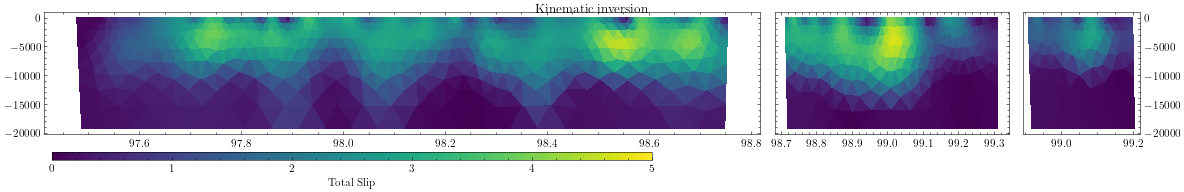

In [86]:
fig = plt.figure(figsize=(15, 2), dpi=80)

gs0 = gridspec.GridSpec(1, 4, figure=fig,width_ratios=[1,1,1,0.5])

ax1 = fig.add_subplot(gs0[0, :2])
ax2 = fig.add_subplot(gs0[0, 2])
ax3 = fig.add_subplot(gs0[0, 3])

im = ax1.tripcolor(triang1,Fault_1.intensity,vmin=0.0,vmax=5.0)
ax2.tripcolor(triang2,Fault_2.intensity,vmin=0.0,vmax=5.0)
ax3.tripcolor(triang3,Fault_3.intensity,vmin=0.0,vmax=5.0)




ax2.set_yticklabels("")
ax3.yaxis.tick_right()
plt.tight_layout()

cax = fig.add_axes([0.05, 0.0, 0.5, 0.05])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Total Slip')
fig.suptitle("Kinematic inversion")